<div class="alert alert-light" role="alert">
  <h4 class="alert-heading">What's the purpose of this notebook?</h4>
  <hr>
  <p class="mb-0">This book is meant to show how to solve a classification problem with imbalanced data in an elegant fashion by using Gradient Boost Decision Trees (GBDT) from the XGBoost library and imbalanced-learn pipeline for preprocessing, resampling and fitting. The dataset used here consists of data related to existing and churned credit card customers.
      
      In this notebook, only the relevant cells are shown in the preview state.
   </p>
</div>

<div class="alert alert-light" role="alert">
  <h4 class="alert-heading">Business Requirements</h4>
  <hr>
  <p class="mb-0">A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate if one could predict for them who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction.
   </p>
</div>

In [19]:
# Import data manipulation and vizualization libraries
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import os

# Import preprocessing and composing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# Import metrics tools
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, classification_report, confusion_matrix

# Import fitting tools
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Import data
df = pd.read_csv("/kaggle/input/credit-card-customers/BankChurners.csv", usecols=list(range(0,21)))
df2 = pd.read_csv("/kaggle/input/credit-card-customers/BankChurners.csv")

In [4]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [5]:
df2.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


## Step 1: Data exploration

#### Data exploration and feature selection

These are the input features initially considered to be relevant for the model according to the requirements:
- Customer's age in years (Customer_Age)
- Customer's gender (Gender)
- Number of the customer's dependents (Dependent_count)
- Customer's educational qualification (Education_Level)
- Customer's marital status (Marital_Status)
- Customer's annual income level (Income_Category)
- Type of credit card held by the customer (Card_Category)
- Period of relationship with the bank (Months_on_book)
- Total of bank products held by the customer (Total_Relationship_Count)
- Amount of inactive in the last 12 months (Months_Inactive_12_mon)
- Number of contact in the last 12 months (Contacts_Count_12_mon)
- Credit limit on the credit card (Credit_Limit)
- Total revolving balance on the credit card (Total_Revolving_Bal)
- Average of last 12 months of the open to buy credit line (Avg_Open_To_Buy)
- Total transaction amount in the last 12 months (Total_Trans_Amt)
- Total transaction count in the last 12 months (Total_Trans_Ct)
- Average card utilization ration (Avg_Utilization_Ratio)

We'll look for the proportion of classes in the target data:

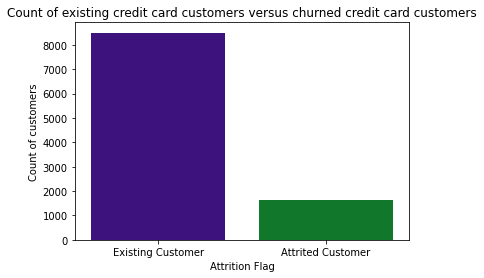

In [6]:
colors = ['#39008E', '#008823']
sns.set_palette(sns.color_palette(colors))
sns.countplot(x="Attrition_Flag", data=df)
plt.title("Count of existing credit card customers versus churned credit card customers")
plt.ylabel("Count of customers")
plt.xlabel("Attrition Flag");

This data is clearly imbalanced as shown in the graph above, as with most of the credit card customer churn datasets. We'll evaluate it after testing our model

Now we'll count the missing values in the data:

In [7]:
# Check the dataframe for any missing data
missing_values = []
columns = df.columns.to_list()
for column in columns:
    null_values = df[column].isnull().sum()
    missing_values.append([column, null_values])
pd.DataFrame(missing_values, columns=["Column Name", "Count of missing Values"]).set_index("Column Name").rename_axis(None)

,Count of missing Values
CLIENTNUM,0
Attrition_Flag,0
Customer_Age,0
Gender,0
Dependent_count,0
Education_Level,0
Marital_Status,0
Income_Category,0
Card_Category,0
Months_on_book,0


Finally, we'll examine the categories for each categorical attribute in the dataset

In [8]:
# Print the categories for each categorical attribute
pd.set_option('display.max_colwidth', 0)
cat = []
for col_name in df.select_dtypes(include=['object']).columns:
    categories_list = df[col_name].value_counts().index.to_list()
    cat.append([col_name, categories_list])
pd.DataFrame(cat, columns=["Column Name", "Categories"]).set_index("Column Name").rename_axis(None)

,Categories
Attrition_Flag,"[Existing Customer, Attrited Customer]"
Gender,"[F, M]"
Education_Level,"[Graduate, High School, Unknown, Uneducated, College, Post-Graduate, Doctorate]"
Marital_Status,"[Married, Single, Unknown, Divorced]"
Income_Category,"[Less than $40K, $40K - $60K, $80K - $120K, $60K - $80K, Unknown, $120K +]"
Card_Category,"[Blue, Silver, Gold, Platinum]"


Some categories are marked as **Unknown** in the 'Education_Level', 'Marital_Status' and 'Income_Category' attributes. Let's see how many of these values are in the dataset:

In [9]:
print("Observations with unknown values in at least one of the attributes: {} out of {}".format(
    (df[(df["Education_Level"] == "Unknown") | 
   (df["Marital_Status"] == "Unknown") | 
   (df["Income_Category"] == "Unknown")].shape[0]), df.shape[0]))

Observations with unknown values in at least one of the attributes: 3046 out of 10127


Treating **Unknown** categories in the observations as missing values would imply a significant data loss. As it would be impossible to input the values, we'll treat them as another category, labeling them as zeros when encoding these features

#### Feature selection

We'll query the selected features before preprocessing the data:

In [10]:
features = df.iloc[:,1:] #get otu the client number because this could not be used as feature
x = features.iloc[:,1:] # take all features except for the Attrition_flag -> target
y = features.iloc[:,0] # take the target feature
features.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Step 2: transforming and fitting

We'll transform, resample and fit our model in a pipeline while executing a grid search to adjust hyperparameters.

Before working with XGBoost, we must ensure that the target variable is encoded before building the pipeline as XGBoost no longer supports label encoding. Still, this doesn't represent a data leakage issue in this particular problem because the outcome variable is always expected to take two classes (existing and attrited customers)

In [11]:
%%time

# Transform output variable (necessary to make XGBoost Work)
y.replace(to_replace = ["Existing Customer", "Attrited Customer"], value = [0,1], inplace = True)

# Train/Test split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)

# Defining the encoding variables
ordinal_enc_variables = ["Education_Level", "Income_Category", "Card_Category"]
one_hot_enc_variables = ["Gender","Marital_Status"]

# Defining ordinal categories
edu_lvl = ["Unknown", "Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate"]
income_cat = ["Unknown", "Less than $40K", "$40K - $60K", "$80K - $120K", "$60K - $80K", "$120K +"]
card_cat = ["Blue", "Silver", "Gold", "Platinum"]
attrition_cat = ["Existing Customer", "Attrited Customer"]

# Calling the encoder classes
ord_enc = OrdinalEncoder(categories = [edu_lvl, income_cat, card_cat])
one_hot_enc = OneHotEncoder(handle_unknown="ignore")

# Make column transformer
column_transform = make_column_transformer((ord_enc, ordinal_enc_variables),
                                          (one_hot_enc, one_hot_enc_variables),
                                           remainder="passthrough")

# Make pipeline
classifier = XGBClassifier()
pipeline = make_pipeline(column_transform, SMOTE(), StandardScaler(), classifier)


# Set parameters values for grid
param_grid = {
    "xgbclassifier__learning_rate":[0.01, 0.3, 0.5],
    "xgbclassifier__n_estimators": [10, 100, 200],
    "xgbclassifier__max_depth": [1, 3, 5],
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__use_label_encoder": [False],
    "xgbclassifier__booster": ["gbtree"],
    "xgbclassifier__eval_metric": ["logloss"]}

# Make custom scoring metric
scorer = make_scorer(f1_score, pos_label=1)

# Intantiate GridSearchCV
grid_search_cv = GridSearchCV(pipeline, param_grid, scoring = scorer)

# Fit
model = grid_search_cv.fit(x_train, y_train)

CPU times: user 5min 47s, sys: 27.2 s, total: 6min 14s
Wall time: 1min 38s


In [15]:
%%time

# Transform output variable (necessary to make XGBoost Work)
y.replace(to_replace = ["Existing Customer", "Attrited Customer"], value = [0,1], inplace = True)

# Train/Test split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)

# Defining the encoding variables
ordinal_enc_variables = ["Education_Level", "Income_Category", "Card_Category"]
one_hot_enc_variables = ["Gender","Marital_Status"]

# Defining ordinal categories
edu_lvl = ["Unknown", "Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate"]
income_cat = ["Unknown", "Less than $40K", "$40K - $60K", "$80K - $120K", "$60K - $80K", "$120K +"]
card_cat = ["Blue", "Silver", "Gold", "Platinum"]
attrition_cat = ["Existing Customer", "Attrited Customer"]

# Calling the encoder classes
ord_enc = OrdinalEncoder(categories = [edu_lvl, income_cat, card_cat])
one_hot_enc = OneHotEncoder(handle_unknown="ignore")

# Make column transformer
column_transform = make_column_transformer((ord_enc, ordinal_enc_variables),
                                          (one_hot_enc, one_hot_enc_variables),
                                           remainder="passthrough")

# Make pipeline
classifier = XGBClassifier()
pipeline = make_pipeline(column_transform, StandardScaler(), classifier)


# Set parameters values for grid
param_grid = {
    "xgbclassifier__learning_rate":[0.01, 0.3, 0.5],
    "xgbclassifier__n_estimators": [10, 100, 200],
    "xgbclassifier__max_depth": [1, 3, 5],
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__use_label_encoder": [False],
    "xgbclassifier__booster": ["gbtree"],
    "xgbclassifier__eval_metric": ["logloss"]}

# Make custom scoring metric
scorer = make_scorer(f1_score, pos_label=1)

# Intantiate GridSearchCV
grid_search_cv = GridSearchCV(pipeline, param_grid, scoring = scorer)

# Fit
model_without_smote = grid_search_cv.fit(x_train, y_train)

CPU times: user 2min 40s, sys: 408 ms, total: 2min 40s
Wall time: 44.2 s


In [20]:
%%time

# Transform output variable (necessary to make XGBoost Work)
y.replace(to_replace = ["Existing Customer", "Attrited Customer"], value = [0,1], inplace = True)

# Train/Test split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)

# Defining the encoding variables
ordinal_enc_variables = ["Education_Level", "Income_Category", "Card_Category"]
one_hot_enc_variables = ["Gender","Marital_Status"]

# Defining ordinal categories
edu_lvl = ["Unknown", "Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate"]
income_cat = ["Unknown", "Less than $40K", "$40K - $60K", "$80K - $120K", "$60K - $80K", "$120K +"]
card_cat = ["Blue", "Silver", "Gold", "Platinum"]
attrition_cat = ["Existing Customer", "Attrited Customer"]

# Calling the encoder classes
ord_enc = OrdinalEncoder(categories = [edu_lvl, income_cat, card_cat])
one_hot_enc = OneHotEncoder(handle_unknown="ignore")

# Make column transformer
column_transform = make_column_transformer((ord_enc, ordinal_enc_variables),
                                          (one_hot_enc, one_hot_enc_variables),
                                           remainder="passthrough")

# Make pipeline
classifier = XGBClassifier()
pipeline = make_pipeline(column_transform, MinMaxScaler(), classifier)


# Set parameters values for grid
param_grid = {
    "xgbclassifier__learning_rate":[0.01, 0.3, 0.5],
    "xgbclassifier__n_estimators": [10, 100, 200],
    "xgbclassifier__max_depth": [1, 3, 5],
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__use_label_encoder": [False],
    "xgbclassifier__booster": ["gbtree"],
    "xgbclassifier__eval_metric": ["logloss"]}

# Make custom scoring metric
scorer = make_scorer(f1_score, pos_label=1)

# Intantiate GridSearchCV
grid_search_cv = GridSearchCV(pipeline, param_grid, scoring = scorer)

# Fit
model_without_smote_minmax = grid_search_cv.fit(x_train, y_train)

CPU times: user 2min 41s, sys: 450 ms, total: 2min 42s
Wall time: 44.7 s


## Step 3: evaluation

We'll evaluate against our test data by using precision, recall and F1 scores:

In [12]:
gbdt_predictions = model.predict(x_test)
scores = [["Precision score", precision_score(gbdt_predictions, y_test, pos_label = 1)],
["Recall score", recall_score(gbdt_predictions, y_test, pos_label = 1)],
["F1 score", f1_score(gbdt_predictions, y_test, pos_label = 1)]]
pd.DataFrame(scores, columns=["Metric", "Score"])

,Metric,Score
0,Precision score,0.898734
1,Recall score,0.914163
2,F1 score,0.906383


In [17]:
gbdt_predictions_without_smote = model_without_smote.predict(x_test)
scores = [["Precision score", precision_score(gbdt_predictions_without_smote, y_test, pos_label = 1)],
["Recall score", recall_score(gbdt_predictions_without_smote, y_test, pos_label = 1)],
["F1 score", f1_score(gbdt_predictions_without_smote, y_test, pos_label = 1)]]
pd.DataFrame(scores, columns=["Metric", "Score"])

,Metric,Score
0,Precision score,0.891949
1,Recall score,0.923246
2,F1 score,0.907328


In [21]:
gbdt_predictions_without_smote_minmax = model_without_smote_minmax.predict(x_test)
scores = [["Precision score", precision_score(gbdt_predictions_without_smote_minmax, y_test, pos_label = 1)],
["Recall score", recall_score(gbdt_predictions_without_smote_minmax, y_test, pos_label = 1)],
["F1 score", f1_score(gbdt_predictions_without_smote_minmax, y_test, pos_label = 1)]]
pd.DataFrame(scores, columns=["Metric", "Score"])

,Metric,Score
0,Precision score,0.887379
1,Recall score,0.938398
2,F1 score,0.912176


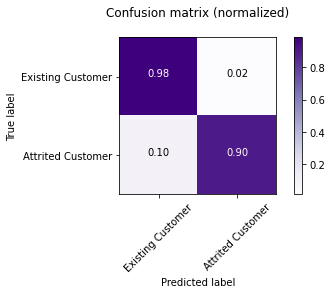

In [13]:
# Define plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, gbdt_predictions, labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Existing Customer','Attrited Customer'],
                      normalize=True, title="Confusion matrix (normalized)\n")

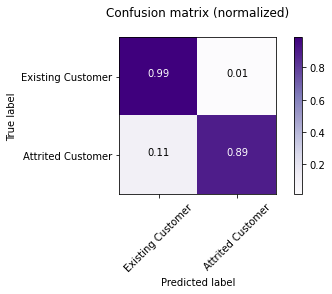

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, gbdt_predictions_without_smote, labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Existing Customer','Attrited Customer'],
                      normalize=True, title="Confusion matrix (normalized)\n")

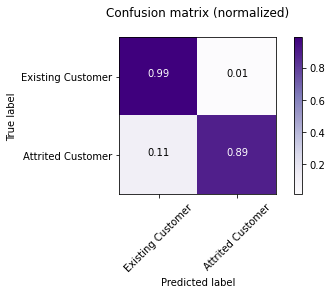

In [22]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, gbdt_predictions_without_smote_minmax, labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Existing Customer','Attrited Customer'],
                      normalize=True, title="Confusion matrix (normalized)\n")

## Final remarks

This notebook has accomplished to show a simple and elegant way to solve an imbalanced classification problem by using XGBoost library and an imbalanced-learn pipeline for transforming, resampling and fitting.

Scores generated here indicate that the model built here is reliable for the problem in question, with little variation between precision and recall scores. Comments related to this notebook are always appreciated.